In [2]:
from google.colab import drive
drive.mount('/content/drive')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mounted at /content/drive
Thu Dec  7 10:37:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

In [ ]:
pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import SimpleITK as sitk
import random
from scipy import ndimage
from os.path import join
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import skimage.transform  as sktf
import glob
# import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class LITS_slicing_train_val:
    def __init__(self, raw_dataset_root_path,slice_dataset_root_path):
        self.raw_dataset_root_path = raw_dataset_root_path
        self.slice_dataset_root_path = slice_dataset_root_path
        self.valid_rate = 0.2
        self.fillters = 20
        self.rs_shape = (128,128,1)
        self.tumor_label = True
        self.upper = 200
        self.lower = -200
        self.xy_down_scale = 0.25
        self.slice_down_scale = 1
        self.expand_slice = 20
        self.size = 48

    def slice_data(self):
        if not os.path.exists(self.slice_dataset_root_path):
            os.makedirs(join(self.slice_dataset_root_path,'ct'))
            os.makedirs(join(self.slice_dataset_root_path, 'label'))

        file_list = sorted(os.listdir(join(self.raw_dataset_root_path,'ct')))
        # file_list = ['volume-0.nii']
        Numbers = len(file_list)
        print('Total numbers of samples is :',Numbers)
        for ct_file,i in zip(file_list,range(Numbers)):
            print("********* {} | {}/{} *********".format(ct_file, i+1,Numbers))
            ct_path = os.path.join(self.raw_dataset_root_path, 'ct', ct_file)
            seg_path = os.path.join(self.raw_dataset_root_path, 'label', ct_file.replace('volume', 'segmentation'))
            self.process(ct_file, ct_path, seg_path, self.rs_shape)

    def process(self, ct_file, ct_path, seg_path, rs_shape):
        ct = sitk.ReadImage(ct_path, sitk.sitkInt16)
        ct_array = sitk.GetArrayFromImage(ct)
        seg = sitk.ReadImage(seg_path, sitk.sitkInt8)
        seg_array = sitk.GetArrayFromImage(seg)
        print("Ori shape:",ct_array.shape, seg_array.shape)

        if self.tumor_label:
            seg_array[seg_array <= 1] = 0
            seg_array[seg_array > 1] = 1

        ct_array[ct_array > self.upper] = self.upper
        ct_array[ct_array < self.lower] = self.lower

        z = np.any(seg_array, axis=(1, 2))
        print(z.shape)
        try:
            start_slice, end_slice = np.where(z)[0][[0, -1]]
        except:
            print ("Don't have tumor at this volume")
            return

        if start_slice - self.expand_slice < 0:
            start_slice = 0
        else:
            start_slice -= self.expand_slice

        if end_slice + self.expand_slice >= seg_array.shape[0]:
            end_slice = seg_array.shape[0] - 1
        else:
            end_slice += self.expand_slice

        print("Cut out range:",str(start_slice) + '--' + str(end_slice))
        if end_slice - start_slice + 1 < self.size:
            print('Too little slice，give up the sample:', ct_path)
            return None,None

        ct_array = ct_array[start_slice:end_slice + 1, :, :]
        # ct_slice = ct_array[85,:,:]
        # np.save('test.npy', ct_slice)
        seg_array = seg_array[start_slice:end_slice + 1, :, :]

        print("Preprocessed shape:",ct_array.shape,seg_array.shape)
        new_ct = sitk.GetImageFromArray(ct_array)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        # print(ct.GetSpacing())
        # new_ct.SetSpacing((ct.GetSpacing()[0] * int(1 / self.xy_down_scale), ct.GetSpacing()[1] * int(1 / self.xy_down_scale), self.slice_down_scale))
        # print(new_ct.GetSpacing())

        new_seg = sitk.GetImageFromArray(seg_array)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        # new_seg.SetSpacing((ct.GetSpacing()[0] * int(1 / self.xy_down_scale), ct.GetSpacing()[1] * int(1 / self.xy_down_scale), self.slice_down_scale))
        sum_tumor_pixel = 0
        num_slice = 0
        ct_array = sitk.GetArrayFromImage(new_ct)
        deep_ct_array = ct_array.shape[0]

        seg_array = sitk.GetArrayFromImage(new_seg)
        deep_seg_array = seg_array.shape[0]

        print("Ori shape volume after filter:",ct_array.shape, seg_array.shape)
        print("Ori deep volume after filter:",deep_ct_array, deep_seg_array)

        for i in range(0, deep_ct_array):
            sum_tumor_pixel = np.sum(seg_array[i,:,:] > 0)
            print("==== sum_tumor_pixel of slice {} of {} = {} ====".format(i, ct_file, sum_tumor_pixel))
            if(sum_tumor_pixel < self.fillters):
                continue
            else:
                print("==== slicing {} | {}/{} ====".format(ct_file, num_slice, deep_seg_array))
                ct_rs = sktf.resize(ct_array[i,:,:], rs_shape, mode = 'constant', preserve_range = True)
                ct_rs = (ct_rs - ct_rs.min())/((ct_rs.max()-ct_rs.min()))
                ct_rs = ct_rs.astype(np.float32)

                label_rs = sktf.resize(seg_array[i,:,:], rs_shape, mode = 'constant', preserve_range = True)
                label_rs = label_rs > 0.5
                label_rs = label_rs.astype(np.float32)
                path_slice_ct = os.path.join(self.slice_dataset_root_path, 'ct', ct_file.replace('.nii', f"_slice_{num_slice}.npy"))
                path_slice_label = os.path.join(self.slice_dataset_root_path, 'label', ct_file.replace('volume', 'segmentation').replace('.nii', f"_slice_{num_slice}.npy"))
                np.save(path_slice_ct, ct_rs)
                print("slice ct shape:",ct_rs.shape)
                np.save(path_slice_label, label_rs)
                print("slice label shape:", label_rs.shape)
                num_slice += 1

    def count_num_slice(self):
        slice_name_list_ct = os.listdir(join(self.slice_dataset_root_path, "ct"))
        slice_num = len(slice_name_list_ct)
        print('the sliced total numbers of samples ct is :', slice_num)
        slice_name_list_label = os.listdir(join(self.slice_dataset_root_path, "label"))
        slice_num = len(slice_name_list_label)
        print('the sliced total numbers of samples label is :', slice_num)

In [ ]:
#main
raw_dataset_root_path = '/content/drive/MyDrive/Liver Segmentation/Data/raw_dataset/train_val/'
slice_dataset_root_path = '/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_128_new/train_val/'

tool = LITS_slicing_train_val(raw_dataset_root_path,slice_dataset_root_path)
tool.slice_data()
tool.count_num_slice()

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
==== sum_tumor_pixel of slice 49 of volume-90.nii = 1046 ====
==== slicing volume-90.nii | 29/209 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 50 of volume-90.nii = 1075 ====
==== slicing volume-90.nii | 30/209 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 51 of volume-90.nii = 1139 ====
==== slicing volume-90.nii | 31/209 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 52 of volume-90.nii = 1208 ====
==== slicing volume-90.nii | 32/209 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 53 of volume-90.nii = 1295 ====
==== slicing volume-90.nii | 33/209 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 54 of volume-90.nii = 1493 ====
==== slicing volume-90.nii | 34/209 ====
slice ct s

In [ ]:
tool = LITS_slicing_train_val(raw_dataset_root_path,slice_dataset_root_path)
# tool.slice_data()
tool.count_num_slice()

the sliced total numbers of samples ct is : 6204
the sliced total numbers of samples label is : 6204


In [ ]:
class LITS_slicing_test:
    def __init__(self, raw_dataset_root_path,slice_dataset_root_path):
        self.raw_dataset_root_path = raw_dataset_root_path
        self.slice_dataset_root_path = slice_dataset_root_path
        self.valid_rate = 0.2
        self.fillters = 20
        self.rs_shape = (128,128,1)
        self.tumor_label = True
        self.upper = 200
        self.lower = -200
        self.xy_down_scale = 0.25
        self.slice_down_scale = 1
        self.expand_slice = 20
        self.size = 48

    def slice_data(self):
        if not os.path.exists(self.slice_dataset_root_path):
            os.makedirs(join(self.slice_dataset_root_path,'ct'))
            os.makedirs(join(self.slice_dataset_root_path, 'label'))

        file_list = sorted(os.listdir(join(self.raw_dataset_root_path,'ct')))
        # file_list = ['volume-0.nii']
        Numbers = len(file_list)
        print('Total numbers of samples is :',Numbers)
        for ct_file,i in zip(file_list,range(Numbers)):
            print("********* {} | {}/{} *********".format(ct_file, i+1,Numbers))
            ct_path = os.path.join(self.raw_dataset_root_path, 'ct', ct_file)
            seg_path = os.path.join(self.raw_dataset_root_path, 'label', ct_file.replace('volume', 'segmentation'))
            self.process(ct_file, ct_path, seg_path, self.rs_shape)

    def process(self, ct_file, ct_path, seg_path, rs_shape):
        ct = sitk.ReadImage(ct_path, sitk.sitkInt16)
        ct_array = sitk.GetArrayFromImage(ct)
        seg = sitk.ReadImage(seg_path, sitk.sitkInt8)
        seg_array = sitk.GetArrayFromImage(seg)
        print("Ori shape:",ct_array.shape, seg_array.shape)

        if self.tumor_label:
            seg_array[seg_array <= 1] = 0
            seg_array[seg_array > 1] = 1

        ct_array[ct_array > self.upper] = self.upper
        ct_array[ct_array < self.lower] = self.lower

        z = np.any(seg_array, axis=(1, 2))
        print(z.shape)
        try:
            start_slice, end_slice = np.where(z)[0][[0, -1]]
        except:
            print ("Don't have tumor at this volume")
            return

        if start_slice - self.expand_slice < 0:
            start_slice = 0
        else:
            start_slice -= self.expand_slice

        if end_slice + self.expand_slice >= seg_array.shape[0]:
            end_slice = seg_array.shape[0] - 1
        else:
            end_slice += self.expand_slice

        print("Cut out range:",str(start_slice) + '--' + str(end_slice))
        if end_slice - start_slice + 1 < self.size:
            print('Too little slice，give up the sample:', ct_path)
            return None,None

        ct_array = ct_array[start_slice:end_slice + 1, :, :]
        # ct_slice = ct_array[85,:,:]
        # np.save('test.npy', ct_slice)
        seg_array = seg_array[start_slice:end_slice + 1, :, :]

        print("Preprocessed shape:",ct_array.shape,seg_array.shape)
        new_ct = sitk.GetImageFromArray(ct_array)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        # print(ct.GetSpacing())
        # new_ct.SetSpacing((ct.GetSpacing()[0] * int(1 / self.xy_down_scale), ct.GetSpacing()[1] * int(1 / self.xy_down_scale), self.slice_down_scale))
        # print(new_ct.GetSpacing())

        new_seg = sitk.GetImageFromArray(seg_array)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        # new_seg.SetSpacing((ct.GetSpacing()[0] * int(1 / self.xy_down_scale), ct.GetSpacing()[1] * int(1 / self.xy_down_scale), self.slice_down_scale))
        sum_tumor_pixel = 0
        num_slice = 0
        ct_array = sitk.GetArrayFromImage(new_ct)
        deep_ct_array = ct_array.shape[0]

        seg_array = sitk.GetArrayFromImage(new_seg)
        deep_seg_array = seg_array.shape[0]

        print("Ori shape volume after filter:",ct_array.shape, seg_array.shape)
        print("Ori deep volume after filter:",deep_ct_array, deep_seg_array)

        for i in range(0, deep_ct_array):
            sum_tumor_pixel = np.sum(seg_array[i,:,:] > 0)
            print("==== sum_tumor_pixel of slice {} of {} = {} ====".format(i, ct_file, sum_tumor_pixel))
            if(sum_tumor_pixel < self.fillters):
                continue
            else:
                print("==== slicing {} | {}/{} ====".format(ct_file, num_slice, deep_seg_array))
                ct_rs = sktf.resize(ct_array[i,:,:], rs_shape, mode = 'constant', preserve_range = True)
                ct_rs = (ct_rs - ct_rs.min())/((ct_rs.max()-ct_rs.min()))
                ct_rs = ct_rs.astype(np.float32)

                label_rs = sktf.resize(seg_array[i,:,:], rs_shape, mode = 'constant', preserve_range = True)
                label_rs = label_rs > 0.5
                label_rs = label_rs.astype(np.float32)
                path_slice_ct = os.path.join(self.slice_dataset_root_path, 'ct', ct_file.replace('.nii', f"_slice_{num_slice}.npy"))
                path_slice_label = os.path.join(self.slice_dataset_root_path, 'label', ct_file.replace('volume', 'segmentation').replace('.nii', f"_slice_{num_slice}.npy"))
                np.save(path_slice_ct, ct_rs)
                print("slice ct shape:",ct_rs.shape)
                np.save(path_slice_label, label_rs)
                print("slice label shape:", label_rs.shape)
                num_slice += 1

    def count_num_slice(self):
        slice_name_list_ct = os.listdir(join(self.slice_dataset_root_path, "ct"))
        slice_num = len(slice_name_list_ct)
        print('the sliced total numbers of samples ct is :', slice_num)
        slice_name_list_label = os.listdir(join(self.slice_dataset_root_path, "label"))
        slice_num = len(slice_name_list_label)
        print('the sliced total numbers of samples label is :', slice_num)

In [ ]:
#main
raw_dataset_root_path = '/content/drive/MyDrive/Liver Segmentation/Data/raw_dataset/test/'
slice_dataset_root_path = '/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_128_new/test/'

tool = LITS_slicing_test(raw_dataset_root_path,slice_dataset_root_path)
tool.slice_data()
tool.count_num_slice()

Total numbers of samples is : 20
********* volume-27.nii | 1/20 *********
Ori shape: (861, 512, 512) (861, 512, 512)
(861,)
Cut out range: 360--562
Preprocessed shape: (203, 512, 512) (203, 512, 512)
Ori shape volume after filter: (203, 512, 512) (203, 512, 512)
Ori deep volume after filter: 203 203
==== sum_tumor_pixel of slice 0 of volume-27.nii = 0 ====
==== sum_tumor_pixel of slice 1 of volume-27.nii = 0 ====
==== sum_tumor_pixel of slice 2 of volume-27.nii = 0 ====
==== sum_tumor_pixel of slice 3 of volume-27.nii = 0 ====
==== sum_tumor_pixel of slice 4 of volume-27.nii = 0 ====
==== sum_tumor_pixel of slice 5 of volume-27.nii = 0 ====
==== sum_tumor_pixel of slice 6 of volume-27.nii = 0 ====
==== sum_tumor_pixel of slice 7 of volume-27.nii = 0 ====
==== sum_tumor_pixel of slice 8 of volume-27.nii = 0 ====
==== sum_tumor_pixel of slice 9 of volume-27.nii = 0 ====
==== sum_tumor_pixel of slice 10 of volume-27.nii = 0 ====
==== sum_tumor_pixel of slice 11 of volume-27.nii = 0 ====
=

[[[9.4463684e-02]
  [4.9721595e-02]
  [4.9701501e-02]
  ...
  [4.9701501e-02]
  [4.9721595e-02]
  [9.4463684e-02]]

 [[4.9721595e-02]
  [4.4619974e-05]
  [2.2310485e-05]
  ...
  [2.2310485e-05]
  [4.4619974e-05]
  [4.9721595e-02]]

 [[4.9701501e-02]
  [2.2310485e-05]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [2.2310485e-05]
  [4.9701501e-02]]

 ...

 [[4.9701501e-02]
  [2.2310485e-05]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [2.2310485e-05]
  [4.9701501e-02]]

 [[4.9721595e-02]
  [4.4619974e-05]
  [2.2310485e-05]
  ...
  [2.2310485e-05]
  [4.4619974e-05]
  [4.9721595e-02]]

 [[9.4463684e-02]
  [4.9721595e-02]
  [4.9701501e-02]
  ...
  [4.9701501e-02]
  [4.9721595e-02]
  [9.4463684e-02]]]


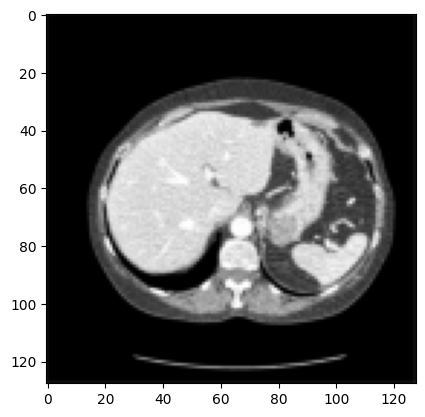

In [ ]:
im = np.load('/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_128_new/train_val/ct/volume-99_slice_51.npy')
print(im)
plt.imshow(im, cmap = 'gray')

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


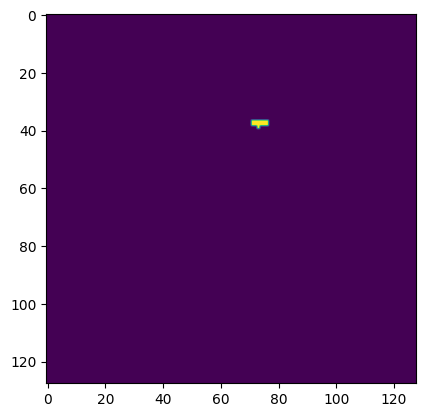

In [ ]:
im = np.load('/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_128_new/train_val/label/segmentation-99_slice_51.npy')
print(im)
plt.imshow(im)

In [9]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.3 MB/s eta 0:00:00


In [3]:
path_test_ct_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path/Test/ct.txt"
path_test_label_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path/Test/label.txt"

In [4]:
# for read ct test data and label training
image_test = []
with open(path_test_ct_txt, "r") as input:
    image_test = input.read().split(',')

In [5]:
# for read ct training dataset and label training
mask_test = []
with open(path_test_label_txt, "r") as input:
    mask_test = input.read().split(',')

In [6]:
def load_from_directory_label(image_mask):
    imgs = []
    print(len(image_mask))
    for i in range(0, len(image_mask)):
        img = np.load(image_mask[i])
        # img = np.expand_dims(img, axis = -1)
        imgs.append(img)
    return np.array(imgs)

In [7]:
def load_from_directory_ct(image_test):
    imgs = []
    print(len(image_test))
    for i in range(0, len(image_test)):
        img = np.load(image_test[i])
        # img = np.expand_dims(img, axis = -1)
        imgs.append(img)
    return np.array(imgs)

In [8]:
X = []
Y = []

X = load_from_directory_ct(image_test)
Y = load_from_directory_label(mask_test)

690
690


In [48]:
print(X.shape)

(690, 128, 128, 1)


In [196]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras import backend as K
from skimage.color import label2rgb
def visualize_segmentation(X,Y,num_samples=10,seed=None, subfig_size = 5):
    if seed is not None:
        np.random.seed(seed)
    metric = tfa.metrics.F1Score(1,average='micro',threshold=0.5)
    ridx = np.random.choice(X.shape[0],num_samples,False)
    im = X[ridx][:,:,:,0]
    mk = Y[ridx][:,:,:,0]

    fig,axes = plt.subplots(
        nrows=2,
        ncols=4,
        figsize=(subfig_size*3,subfig_size*num_samples),
    )
    # if num_samples < 2:
    #     for ax, col in zip(axes, ['Img', 'Ground Truth']):
    #         ax.set_title(col)
    # else:
    #     for ax, col in zip(axes[0], ['Img', 'Ground Truth']):
    #         ax.set_title(col)

    for i,(ax1,ax2, ax3, ax4) in enumerate(axes):
      print(i)
      if i == 0:
        ax1.imshow(im[0])
        ax1.set(xticks=[], yticks=[])
        ax2.imshow(im[1])
        ax2.set(xticks=[], yticks=[])
        ax3.imshow(im[2])
        ax3.set(xticks=[], yticks=[])
        ax4.imshow(im[3])
        ax4.set(xticks=[], yticks=[])
      else:
        ax1.imshow(label2rgb(mk[0],im[0], colors=['yellow',], alpha=1, bg_label=0, bg_color=None))
        ax1.set(xticks=[], yticks=[])
        ax2.imshow(label2rgb(mk[1],im[1], colors=['yellow',], alpha=1, bg_label=0, bg_color=None))
        ax2.set(xticks=[], yticks=[])
        ax3.imshow(label2rgb(mk[2],im[2], colors=['yellow',], alpha=1, bg_label=0, bg_color=None))
        ax3.set(xticks=[], yticks=[])
        ax4.imshow(label2rgb(mk[3],im[3], colors=['yellow',], alpha=1, bg_label=0, bg_color=None))
        ax4.set(xticks=[], yticks=[])
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()

0
1


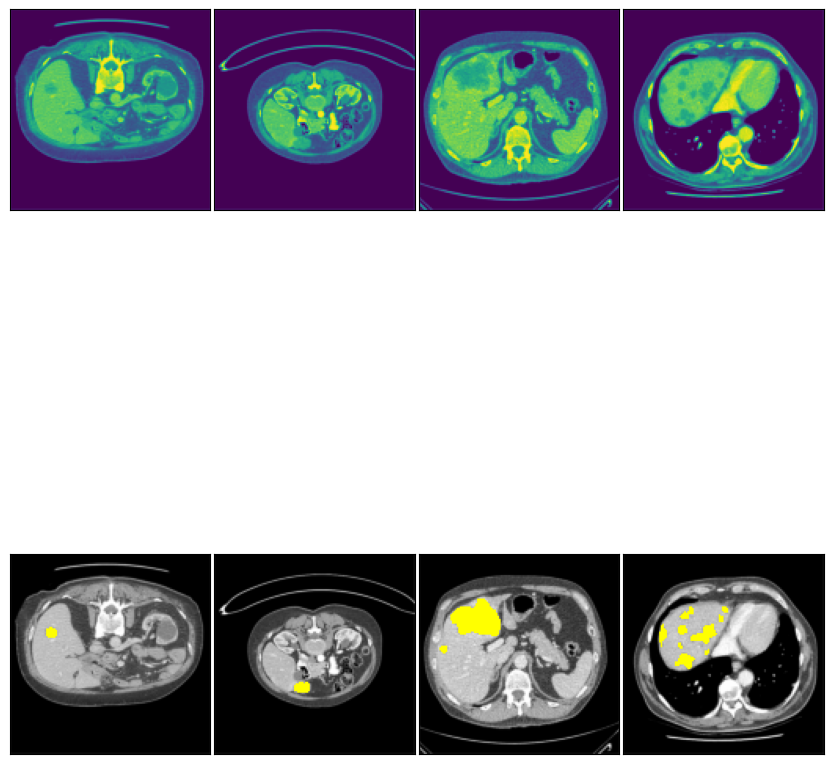

In [197]:
visualize_segmentation(
    X=X,
    Y=Y,
    num_samples=4,
    seed=45,
    subfig_size=3.5
)